
<center><h1>Intelligence Artificielle Avancée</h1></center>
<center><h2>TP7</h2></center>

# Importation des librairies

In [50]:
!pip install bayesian-optimization

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split

from bayes_opt import BayesianOptimization

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, LSTM, GRU
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.api._v2.keras.callbacks import ModelCheckpoint, EarlyStopping

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

warnings.filterwarnings("ignore")

# Configaration GPU

In [43]:
device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
  print("Found GPU at:{}".format(device_name))
else:
  device_name="/device:CPU:0"
  print("No GPU")

Found GPU at:/device:GPU:0


# Importation du dataset

In [2]:
df = pd.read_csv("sentiment-tweets.csv")

df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


# Prétraitement des données

## Sélection des attributs

In [3]:
df_ann = df[['airline_sentiment', 'airline_sentiment_confidence', 'negativereason', 'negativereason_confidence', 'text']]

df_ann.head()

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,text
0,neutral,1.0000,NaN,NaN,@VirginAmerica What @dhepburn said.
1,positive,0.3486,NaN,0.0000,@VirginAmerica plus you've added commercials t...
2,neutral,0.6837,NaN,NaN,@VirginAmerica I didn't today... Must mean I n...
3,negative,1.0000,Bad Flight,0.7033,@VirginAmerica it's really aggressive to blast...
4,negative,1.0000,Can't Tell,1.0000,@VirginAmerica and it's a really big bad thing...


## Encodage des raisons négatives
0 si la valeur est NaN (si il n'y a pas de raison négative) et 1 si la valeur est non NaN (si il y'a une raison négative)

In [4]:
df_ann['negativereason'] = df_ann['negativereason'].notnull().astype('int')

df_ann['negativereason'] = df_ann['negativereason'].fillna(0)
df_ann.head()

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,text
0,neutral,1.0000,0,NaN,@VirginAmerica What @dhepburn said.
1,positive,0.3486,0,0.0000,@VirginAmerica plus you've added commercials t...
2,neutral,0.6837,0,NaN,@VirginAmerica I didn't today... Must mean I n...
3,negative,1.0000,1,0.7033,@VirginAmerica it's really aggressive to blast...
4,negative,1.0000,1,1.0000,@VirginAmerica and it's a really big bad thing...


Si la confiance est égale a NaN on remplace la valeur NaN par 0

In [5]:
df_ann['negativereason_confidence'] = df_ann['negativereason_confidence'].fillna(0)

df_ann

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,text
0,neutral,1.0000,0,0.0000,@VirginAmerica What @dhepburn said.
1,positive,0.3486,0,0.0000,@VirginAmerica plus you've added commercials t...
2,neutral,0.6837,0,0.0000,@VirginAmerica I didn't today... Must mean I n...
3,negative,1.0000,1,0.7033,@VirginAmerica it's really aggressive to blast...
4,negative,1.0000,1,1.0000,@VirginAmerica and it's a really big bad thing...
...,...,...,...,...,...
14635,positive,0.3487,0,0.0000,@AmericanAir thank you we got on a different f...
14636,negative,1.0000,1,1.0000,@AmericanAir leaving over 20 minutes Late Flig...
14637,neutral,1.0000,0,0.0000,@AmericanAir Please bring American Airlines to...
14638,negative,1.0000,1,0.6659,"@AmericanAir you have my money, you change my ..."


## Prétraitement du Texte
### enlever les tag des utilisateurs et les stopwords puis utiliser le stemming

In [12]:
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

corpus = []

for i in range(0, len(df_ann)):

    review = re.sub(r'@\w+\b', '', df_ann['text'][i])
    review = ' '.join(review.split())
    review = re.sub('[^a-zA-Z]', ' ', review)
    review = review.lower()
    review = review.split()

    ps = PorterStemmer()
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]

    review = ' '.join(review)
    corpus.append(review)

corpus

['said',
 'plu ad commerci experi tacki',
 'today must mean need take anoth trip',
 'realli aggress blast obnoxi entertain guest face amp littl recours',
 'realli big bad thing',
 'serious would pay flight seat play realli bad thing fli va',
 'ye nearli everi time fli vx ear worm go away',
 'realli miss prime opportun men without hat parodi http co mwpg grezp',
 'well',
 'amaz arriv hour earli good',
 'know suicid second lead caus death among teen',
 'lt pretti graphic much better minim iconographi',
 'great deal alreadi think nd trip amp even gone st trip yet p',
 'fli fabul seduct sky u take stress away travel http co ahlxhhkiyn',
 'thank',
 'sfo pdx schedul still mia',
 'excit first cross countri flight lax mco heard noth great thing virgin america daystogo',
 'flew nyc sfo last week fulli sit seat due two larg gentleman either side help',
 'fli',
 'know would amazingli awesom bo fll pleas want fli',
 'first fare may three time carrier seat avail select',
 'love graphic http co ut g

In [13]:
df_ann['text'] = corpus

df_ann.head()

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,text
0,neutral,1.0000,0,0.0000,said
1,positive,0.3486,0,0.0000,plu ad commerci experi tacki
2,neutral,0.6837,0,0.0000,today must mean need take anoth trip
3,negative,1.0000,1,0.7033,realli aggress blast obnoxi entertain guest fa...
4,negative,1.0000,1,1.0000,realli big bad thing


### Tokenisation et padding

In [17]:
def get_max_lenght(text):
  lenghts = []
  for t in text:
    lenghts.append(len(t.split(" ")))
  return max(lenghts)

get_max_lenght(df["text"])

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_ann['text'])
sequences = tokenizer.texts_to_sequences(df_ann['text'])

padded_sequences = pad_sequences(sequences, maxlen=36, padding='post')

In [21]:
X_text = np.array(padded_sequences)
X_other_features = np.array(df_ann[['airline_sentiment_confidence', 'negativereason', 'negativereason_confidence']])
X = np.concatenate([X_other_features, X_text], axis=1)

pd.DataFrame(X)

,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
0,1.0000,0.0,0.0000,135.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.3486,0.0,0.0000,418.0,500.0,1019.0,112.0,4420.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.6837,0.0,0.0000,42.0,609.0,257.0,19.0,52.0,81.0,104.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0000,1.0,0.7033,69.0,2698.0,1881.0,3308.0,669.0,1603.0,884.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0000,1.0,1.0000,69.0,358.0,128.0,192.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,0.3487,0.0,0.0000,2.0,38.0,226.0,1.0,312.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14636,1.0000,1.0,1.0000,116.0,56.0,44.0,1.0,1498.0,380.0,56.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14637,1.0000,0.0,0.0000,27.0,404.0,339.0,29.0,10034.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14638,1.0000,1.0,0.6659,263.0,37.0,1.0,121.0,39.0,565.0,35.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
y = np.array(df['airline_sentiment'])

pd.DataFrame(y)

,0
0,neutral
1,positive
2,neutral
3,negative
4,negative
...,...
14635,positive
14636,negative
14637,neutral
14638,negative


In [25]:
X.shape, y.shape

((14640, 39), (14640,))

## Division en set d'entrainement de validation et de teste

In [26]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.33, random_state=True)
X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=0.5, random_state=True)

# Encodage des labels

In [ ]:
label_to_index = {'positive': 0, 'neutral': 1, 'negative': 2}
Y_train = np.array([label_to_index[label] for label in Y_train])
Y_val = np.array([label_to_index[label] for label in Y_val])
Y_test = np.array([label_to_index[label] for label in Y_test])
n_classes = 3
Y_train = to_categorical(Y_train, n_classes)
Y_test = to_categorical(Y_test, n_classes)
Y_val = Y_test = to_categorical(Y_val, n_classes)

In [27]:
X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape

((9808, 39), (9808,), (2416, 39), (2416,), (2416, 39), (2416,))

# Création de l'architecture de notre modèle

In [54]:
def LSTM_GRU_training(nbn_l, nbn_g, nbn_d, dp, bs):
  with tf.device(device_name):

    model = Sequential()

    model.add(LSTM(units=int(nbn_l), activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 1)))

    model.add(LSTM(units=int(nbn_l)*2, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 1)))

    model.add(GRU(units=int(nbn_g), return_sequences=True, activation='relu'))

    model.add(GRU(units=int(nbn_g)*2, activation='relu'))

    model.add(Dense(int(nbn_d), activation='relu'))
    model.add(Dropout(dp))
    model.add(Dense(int(nbn_d)//2, activation='relu'))
    model.add(Dropout(dp))
    model.add(Dense(3, activation='softmax'))  

    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    checkpointer = ModelCheckpoint(filepath='tweet.keras', 
                                   monitor='accuracy', verbose=0, save_best_only=True, 
                                   save_weights_only=False, mode='min', save_freq=1)
    
    early = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, mode='auto')

    history = model.fit(X_train, Y_train,
                            batch_size=int(bs), epochs=100,
                            verbose=0,
                            callbacks = [checkpointer, early],
                            validation_data=(X_val, Y_val))

    return history.history['accuracy']

# Affinage des hyperparamètres

## Utilisation de l'algorithme d'optimisatuon baysien

In [73]:
pbounds = {
    'nbn_l': (64, 1024),
    'nbn_g': (32, 512),
    'nbn_d': (512, 1024),
    'bs': (256, 1024),
    'dp': (0.1, 0.5)
    }


optimizer = BayesianOptimization(
    f=LSTM_GRU_training,
    pbounds=pbounds,
    verbose=0,
    random_state=1,
)

optimizer.maximize(init_points=10, n_iter=10)
print(optimizer.max)

{'target': 0.9576400194206911, 'params': {'bs': 64.1601698370102, 'dp': 0.22827160159044324, 'nbn_d': 1123.1971772677698, 'nbn_g': 273.9845614397863, 'nbn_l': 641.4127667697459}}


# Entrainement du modèle avec les meillieurs hyperparamètres

In [60]:
nbn_d = optimizer.max["params"]["nbn_d"]
nbn_g = optimizer.max["params"]["nbn_g"]
nbn_l = optimizer.max["params"]["nbn_l"]
dp = optimizer.max["params"]["dp"]
bs = optimizer.max["params"]["bs"]
with tf.device(device_name):

  model = Sequential()

  model.add(LSTM(units=int(nbn_l), activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 1)))

  model.add(LSTM(units=int(nbn_l)*2, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 1)))

  model.add(GRU(units=int(nbn_g), return_sequences=True, activation='relu'))

  model.add(GRU(units=int(nbn_g)*2, activation='relu'))

  model.add(Dense(int(nbn_d), activation='relu'))
  model.add(Dropout(dp))
  model.add(Dense(int(nbn_d)//2, activation='relu'))
  model.add(Dropout(dp))
  model.add(Dense(3, activation='softmax'))

  model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

  checkpointer = ModelCheckpoint(filepath='tweet.keras', monitor='accuracy', verbose=0, save_best_only=True, save_weights_only=False, mode='min', save_freq=1)
  early = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, mode='auto')

  history = model.fit(X_train, Y_train,
                          batch_size=int(bs), epochs=100,
                          verbose=2,
                          callbacks = [checkpointer, early],
                          validation_data=(X_val, Y_val))

Epoch: 1/100
154/154 - 296s - loss: 8.2213 - accuracy: 0.4349 - val_loss: 7.9743 - val_accuracy: 0.4178 - 296s/epoch - 4s/step
Epoch: 2/100
154/154 - 330s - loss: 8.2187 - accuracy: 0.4355 - val_loss: 7.9685 - val_accuracy: 0.4183 - 330s/epoch - 4s/step
Epoch: 3/100
154/154 - 302s - loss: 8.2053 - accuracy: 0.4366 - val_loss: 7.9532 - val_accuracy: 0.4197 - 302s/epoch - 4s/step
Epoch: 4/100
154/154 - 279s - loss: 8.2042 - accuracy: 0.4372 - val_loss: 7.9376 - val_accuracy: 0.4204 - 279s/epoch - 4s/step
Epoch: 5/100
154/154 - 291s - loss: 8.1679 - accuracy: 0.4389 - val_loss: 7.9159 - val_accuracy: 0.4234 - 291s/epoch - 4s/step
Epoch: 6/100
154/154 - 289s - loss: 8.1478 - accuracy: 0.4390 - val_loss: 7.8792 - val_accuracy: 0.4247 - 289s/epoch - 4s/step
Epoch: 7/100
154/154 - 289s - loss: 8.1010 - accuracy: 0.4401 - val_loss: 7.8248 - val_accuracy: 0.4284 - 289s/epoch - 4s/step
Epoch: 8/100
154/154 - 305s - loss: 8.0551 - accuracy: 0.4418 - val_loss: 7.7608 - val_accuracy: 0.4314 - 305s/

# Visualisation des résultats

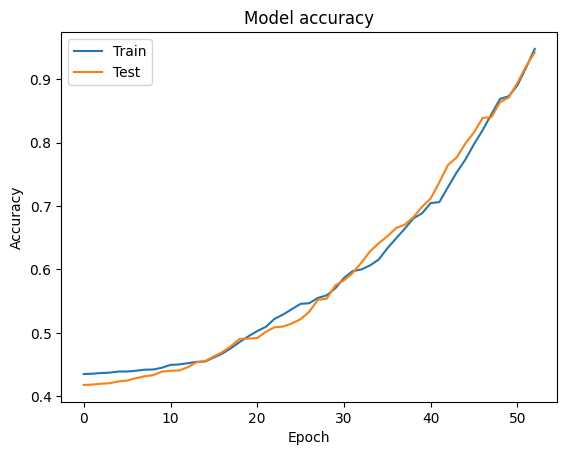

In [61]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

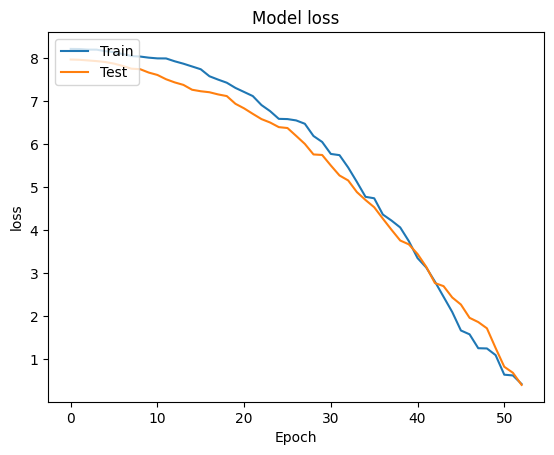

In [62]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Test du modèle

In [70]:
y_predicted = model.predict(X_test)

154/154 [==============================] - 120s 7ms/step


## Visualisation des résultats du test

Text(95.72222222222221, 0.5, 'Truth')

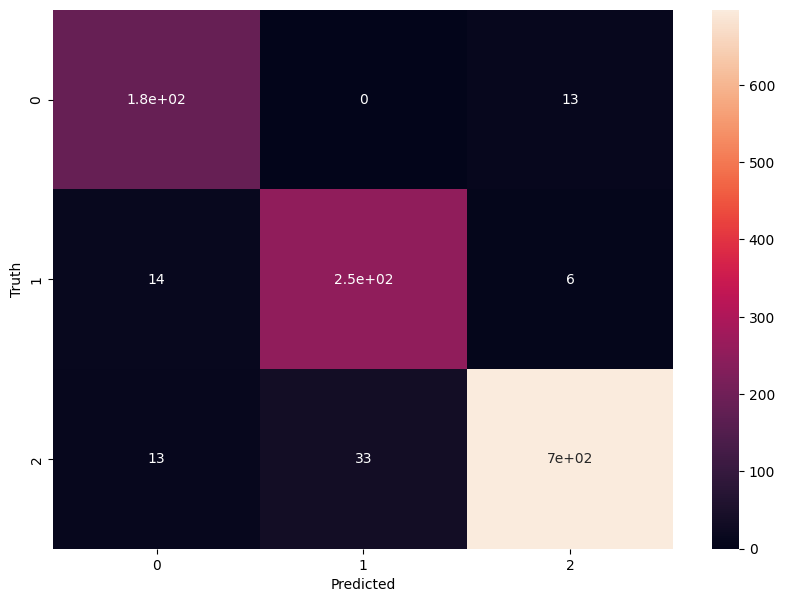

In [68]:
y_predicted_labels = [np.argmax(i) for i in y_predicted]
cm = tf.math.confusion_matrix(labels=Y_test, predictions=y_predicted_labels)

plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')